In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import minimize


# Load and prepare the dataset
def load_data():
    # Load data
    df = pd.read_csv('train.csv')
    
    # Select features
    X = df[['GrLivArea', 'YearBuilt']]
    y = df['SalePrice']
    
    # Split into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_val, y_train, y_val
########################################################
# Problem 1: Blending Implementation
########################################################

class Blending:
    def __init__(self, models, weights=None):
        self.models = models
        self.weights = weights if weights is not None else [1/len(models)] * len(models)
        self.trained_models = []

    def fit(self, X, y):
        self.trained_models = []
        for model in self.models:
            model.fit(X, y)
            self.trained_models.append(model)
        return self

    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.trained_models])
        return np.average(predictions, axis=1, weights=self.weights)


def blending_example():
    # Load data
    X_train, X_val, y_train, y_val = load_data()
    
    # Create some diverse models
    models = [
        # Example 1: Different algorithms
        [LinearRegression(), SVR(kernel='linear'), DecisionTreeRegressor(max_depth=5)],
        
        # Example 2: Different hyperparameters for SVR
        [SVR(kernel='linear'), SVR(kernel='rbf', gamma='scale'), SVR(kernel='poly', degree=2)],
        
        # Example 3: Different preprocessing with linear regression
        [LinearRegression()]  # We'll use different preprocessing for this one
    ]
    
    results = {'Model': [], 'MSE': []}
    
    # Example 1: Different algorithms
    print("\n=== Blending Example 1: Different Algorithms ===")
    # Train individual models
    model1 = LinearRegression().fit(X_train, y_train)
    model2 = SVR(kernel='linear').fit(X_train, y_train)
    model3 = DecisionTreeRegressor(max_depth=5).fit(X_train, y_train)
    
    # Get individual predictions and MSEs
    pred1 = model1.predict(X_val)
    pred2 = model2.predict(X_val)
    pred3 = model3.predict(X_val)
    
    mse1 = mean_squared_error(y_val, pred1)
    mse2 = mean_squared_error(y_val, pred2)
    mse3 = mean_squared_error(y_val, pred3)
    
    print(f"Linear Regression MSE: {mse1:.2f}")
    print(f"SVR MSE: {mse2:.2f}")
    print(f"Decision Tree MSE: {mse3:.2f}")
    
    results['Model'].extend(['Linear Regression', 'SVR', 'Decision Tree'])
    results['MSE'].extend([mse1, mse2, mse3])
    
    # Train blending model
    blending = Blending(models[0]).fit(X_train, y_train)
    blend_pred = blending.predict(X_val)
    blend_mse = mean_squared_error(y_val, blend_pred)
    
    print(f"Blending MSE: {blend_mse:.2f}")
    results['Model'].append('Blending (Example 1)')
    results['MSE'].append(blend_mse)
    
    # Example 2: Different hyperparameters for SVR
    print("\n=== Blending Example 2: Different SVR Hyperparameters ===")
    # Train individual models
    model1 = SVR(kernel='linear').fit(X_train, y_train)
    model2 = SVR(kernel='rbf', gamma='scale').fit(X_train, y_train)
    model3 = SVR(kernel='poly', degree=2).fit(X_train, y_train)
    
    # Get individual predictions and MSEs
    pred1 = model1.predict(X_val)
    pred2 = model2.predict(X_val)
    pred3 = model3.predict(X_val)
    
    mse1 = mean_squared_error(y_val, pred1)
    mse2 = mean_squared_error(y_val, pred2)
    mse3 = mean_squared_error(y_val, pred3)
    
    print(f"SVR (linear) MSE: {mse1:.2f}")
    print(f"SVR (rbf) MSE: {mse2:.2f}")
    print(f"SVR (poly) MSE: {mse3:.2f}")
    
    results['Model'].extend(['SVR (linear)', 'SVR (rbf)', 'SVR (poly)'])
    results['MSE'].extend([mse1, mse2, mse3])
    
    # Train blending model
    blending = Blending(models[1]).fit(X_train, y_train)
    blend_pred = blending.predict(X_val)
    blend_mse = mean_squared_error(y_val, blend_pred)
    
    print(f"Blending MSE: {blend_mse:.2f}")
    results['Model'].append('Blending (Example 2)')
    results['MSE'].append(blend_mse)
    
    # Example 3: Different preprocessing with linear regression
    print("\n=== Blending Example 3: Different Preprocessing ===")
    
    # Create different preprocessed versions of the data
    # Original data
    lr1 = LinearRegression().fit(X_train, y_train)
    pred1 = lr1.predict(X_val)
    mse1 = mean_squared_error(y_val, pred1)
    
    # Standardized data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    lr2 = LinearRegression().fit(X_train_scaled, y_train)
    pred2 = lr2.predict(X_val_scaled)
    mse2 = mean_squared_error(y_val, pred2)
    
    # Log-transformed target
    log_y_train = np.log1p(y_train)
    lr3 = LinearRegression().fit(X_train, log_y_train)
    log_pred3 = lr3.predict(X_val)
    pred3 = np.expm1(log_pred3)
    mse3 = mean_squared_error(y_val, pred3)
    
    print(f"Linear Regression (Original) MSE: {mse1:.2f}")
    print(f"Linear Regression (Standardized) MSE: {mse2:.2f}")
    print(f"Linear Regression (Log Target) MSE: {mse3:.2f}")
    
    results['Model'].extend(['LR (Original)', 'LR (Standardized)', 'LR (Log Target)'])
    results['MSE'].extend([mse1, mse2, mse3])
    
    # Blend predictions
    blend_pred = (pred1 + pred2 + pred3) / 3
    blend_mse = mean_squared_error(y_val, blend_pred)
    
    print(f"Blending MSE: {blend_mse:.2f}")
    results['Model'].append('Blending (Example 3)')
    results['MSE'].append(blend_mse)
    
    # Create a DataFrame for results
    results_df = pd.DataFrame(results)
    print("\n=== Summary of Blending Examples ===")
    print(results_df)
    
    # Plot results for visualization
    plt.figure(figsize=(10, 6))
    plt.bar(results_df['Model'], results_df['MSE'])
    plt.xticks(rotation=45, ha='right')
    plt.title('MSE Comparison of Different Models and Blending')
    plt.ylabel('Mean Squared Error')
    plt.tight_layout()
    plt.show()
    
    return results_df



In [2]:
########################################################
# Problem 2: Bagging Implementation
########################################################

class Bagging:
    def __init__(self, base_estimator, n_estimators=10, bootstrap_ratio=0.8, random_state=None):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.bootstrap_ratio = bootstrap_ratio
        self.random_state = random_state
        self.estimators = []
        
    def _bootstrap_sample(self, X, y):
        n_samples = int(len(X) * self.bootstrap_ratio)
        indices = np.random.choice(len(X), size=n_samples, replace=True)
        return X.iloc[indices] if isinstance(X, pd.DataFrame) else X[indices], y.iloc[indices] if isinstance(y, pd.Series) else y[indices]
        
    def fit(self, X, y):
        self.estimators = []
        
        for i in range(self.n_estimators):
            # Create bootstrap sample
            X_bootstrap, y_bootstrap = self._bootstrap_sample(X, y)
            
            # Clone the estimator and fit
            estimator = type(self.base_estimator)(**self.base_estimator.get_params())
            estimator.fit(X_bootstrap, y_bootstrap)
            
            self.estimators.append(estimator)
            
        return self
    
    def predict(self, X):
        predictions = np.column_stack([estimator.predict(X) for estimator in self.estimators])
        return np.mean(predictions, axis=1)

def bagging_example():
    # Load data
    X_train, X_val, y_train, y_val = load_data()
    
    print("\n=== Bagging Example ===")
    
    # Base model (Decision Tree)
    base_model = DecisionTreeRegressor(max_depth=5)
    base_model.fit(X_train, y_train)
    base_pred = base_model.predict(X_val)
    base_mse = mean_squared_error(y_val, base_pred)
    print(f"Single Decision Tree MSE: {base_mse:.2f}")
    
    # Bagging model
    bagging = Bagging(base_estimator=DecisionTreeRegressor(max_depth=5), n_estimators=50)
    bagging.fit(X_train, y_train)
    bagging_pred = bagging.predict(X_val)
    bagging_mse = mean_squared_error(y_val, bagging_pred)
    print(f"Bagging (50 trees) MSE: {bagging_mse:.2f}")
    
    # Compare with different numbers of estimators
    n_estimators_list = [1, 5, 10, 20, 50, 100]
    mse_list = []
    
    for n_est in n_estimators_list:
        bagging = Bagging(base_estimator=DecisionTreeRegressor(max_depth=5), n_estimators=n_est)
        bagging.fit(X_train, y_train)
        bagging_pred = bagging.predict(X_val)
        bagging_mse = mean_squared_error(y_val, bagging_pred)
        mse_list.append(bagging_mse)
        print(f"Bagging ({n_est} trees) MSE: {bagging_mse:.2f}")
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(n_estimators_list, mse_list, marker='o')
    plt.axhline(y=base_mse, color='r', linestyle='--', label=f'Single Tree MSE: {base_mse:.2f}')
    plt.xlabel('Number of Trees')
    plt.ylabel('Mean Squared Error')
    plt.title('Effect of Number of Trees in Bagging on MSE')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return {'base_mse': base_mse, 'bagging_mse': bagging_mse}



ENSEMBLE LEARNING IMPLEMENTATIONS

PROBLEM 1: BLENDING
--------------------------------------------------

=== Blending Example 1: Different Algorithms ===
Linear Regression MSE: 2495554898.67
SVR MSE: 2695235457.20
Decision Tree MSE: 1844304720.66
Blending MSE: 2091228779.70

=== Blending Example 2: Different SVR Hyperparameters ===
SVR (linear) MSE: 2695235457.20
SVR (rbf) MSE: 7844111028.86
SVR (poly) MSE: 5521984650.56
Blending MSE: 4766113389.98

=== Blending Example 3: Different Preprocessing ===
Linear Regression (Original) MSE: 2495554898.67
Linear Regression (Standardized) MSE: 2495554898.67
Linear Regression (Log Target) MSE: 2051224230.95
Blending MSE: 2279632629.29

=== Summary of Blending Examples ===
                   Model           MSE
0      Linear Regression  2.495555e+09
1                    SVR  2.695235e+09
2          Decision Tree  1.844305e+09
3   Blending (Example 1)  2.091229e+09
4           SVR (linear)  2.695235e+09
5              SVR (rbf)  7.844111e+09
6  

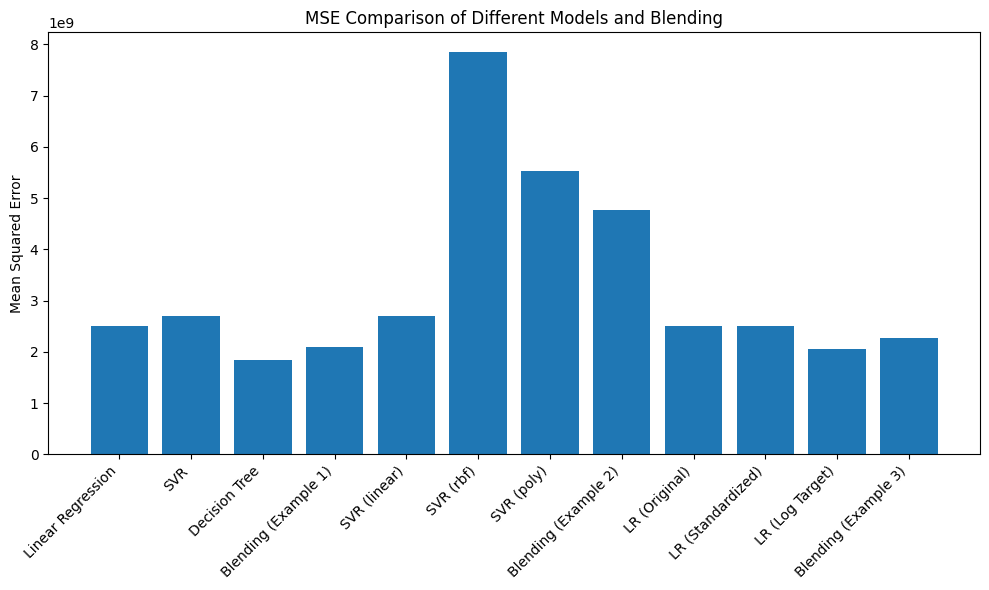


PROBLEM 2: BAGGING
--------------------------------------------------

=== Bagging Example ===
Single Decision Tree MSE: 1844304720.66
Bagging (50 trees) MSE: 1653464170.04
Bagging (1 trees) MSE: 1703138030.67
Bagging (5 trees) MSE: 1506436888.47
Bagging (10 trees) MSE: 1646437063.43
Bagging (20 trees) MSE: 1714480466.36
Bagging (50 trees) MSE: 1728353764.59
Bagging (100 trees) MSE: 1605417645.98


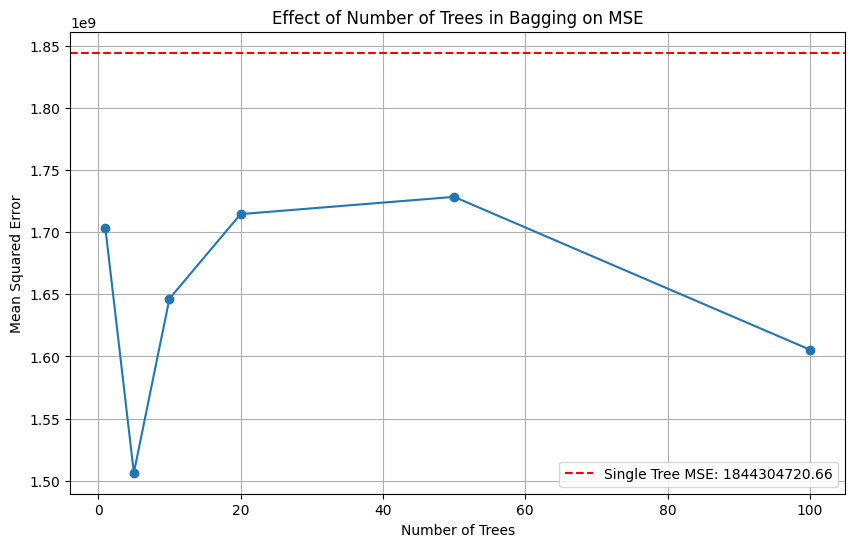


PROBLEM 3: STACKING
--------------------------------------------------

=== Stacking Example ===
Decision Tree MSE: 1564680522.54
Ridge MSE: 2580954531.96
Lasso MSE: 2498059312.36
ElasticNet MSE: 2537826835.19
Random Forest MSE: 1579695340.13
Weighted Ensemble MSE: 1441720496.98

Optimized model weights:
Decision Tree: 0.5144
Ridge: 0.0000
Lasso: 0.0000
ElasticNet: 0.0000
Random Forest: 0.4856

Best Single Model MSE: 1564680522.54
Improvement: 7.86%


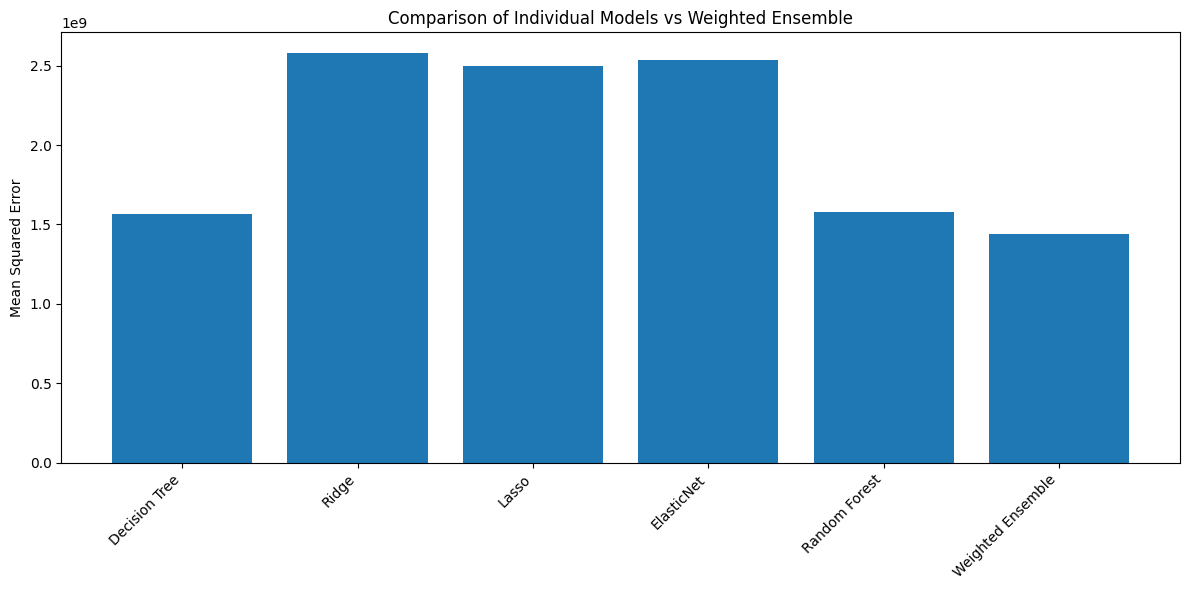


SUMMARY OF RESULTS

Blending Results:
                   Model           MSE
0      Linear Regression  2.495555e+09
1                    SVR  2.695235e+09
2          Decision Tree  1.844305e+09
3   Blending (Example 1)  2.091229e+09
4           SVR (linear)  2.695235e+09
5              SVR (rbf)  7.844111e+09
6             SVR (poly)  5.521985e+09
7   Blending (Example 2)  4.766113e+09
8          LR (Original)  2.495555e+09
9      LR (Standardized)  2.495555e+09
10       LR (Log Target)  2.051224e+09
11  Blending (Example 3)  2.279633e+09

Bagging Results:
Single Model MSE: 1844304720.66
Bagging Model MSE: 1605417645.98
Improvement: 12.95%

Stacking Results:
Best Single Model MSE: 1564680522.54
Stacking Model MSE: 1441720496.98
Improvement: 7.86%


In [3]:
########################################################
# Problem 3: Stacking Implementation
########################################################

class Stacking:
    def __init__(self, base_models, meta_model, cv=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.cv = cv
        self.trained_base_models = []
        self.trained_meta_model = None
        
    def _generate_meta_features(self, X, y, train_indices, val_indices):
        # Train base models on training fold
        fold_trained_models = []
        for model in self.base_models:
            model_clone = type(model)(**model.get_params())
            model_clone.fit(X.iloc[train_indices] if isinstance(X, pd.DataFrame) else X[train_indices], 
                          y.iloc[train_indices] if isinstance(y, pd.Series) else y[train_indices])
            fold_trained_models.append(model_clone)
            
        # Generate predictions on validation fold
        meta_features = np.column_stack([
            model.predict(X.iloc[val_indices] if isinstance(X, pd.DataFrame) else X[val_indices]) 
            for model in fold_trained_models
        ])
        
        return meta_features, y.iloc[val_indices] if isinstance(y, pd.Series) else y[val_indices]
    
    def fit(self, X, y):
        # Generate cross-validation folds
        n_samples = len(X)
        fold_size = n_samples // self.cv
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        
        # Generate meta features through cross-validation
        all_meta_features = []
        all_meta_targets = []
        
        for i in range(self.cv):
            val_indices = indices[i * fold_size:(i + 1) * fold_size]
            train_indices = np.setdiff1d(indices, val_indices)
            
            meta_features, meta_targets = self._generate_meta_features(X, y, train_indices, val_indices)
            all_meta_features.append(meta_features)
            all_meta_targets.append(meta_targets)
        
        # Combine meta features and targets
        meta_features = np.vstack(all_meta_features)
        meta_targets = np.concatenate(all_meta_targets)
        
        # Train meta model
        self.meta_model.fit(meta_features, meta_targets)
        
        # Train base models on full dataset
        self.trained_base_models = []
        for model in self.base_models:
            model_clone = type(model)(**model.get_params())
            model_clone.fit(X, y)
            self.trained_base_models.append(model_clone)
            
        return self
    
    def predict(self, X):
        # Generate predictions from base models
        meta_features = np.column_stack([model.predict(X) for model in self.trained_base_models])
        
        # Make final prediction using meta model
        return self.meta_model.predict(meta_features)


def stacking_example():
    # Load data
    X_train, X_val, y_train, y_val = load_data()
    
    print("\n=== Stacking Example ===")
    
    # Create an enhanced dataset with polynomial features
    from sklearn.preprocessing import PolynomialFeatures, StandardScaler
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Add scaling to help with convergence issues
    scaler = StandardScaler()
    X_train_poly_scaled = scaler.fit_transform(X_train_poly)
    X_val_poly_scaled = scaler.transform(X_val_poly)
    
    # Scale the target variable to help with convergence
    y_scaler = StandardScaler()
    y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    
    # Create specialized base models
    from sklearn.linear_model import Ridge, Lasso, ElasticNet
    from sklearn.ensemble import RandomForestRegressor

    # Increased max_iter and adjusted alpha values to help with convergence
    base_models_specialized = [
        # Use the best performing model from your previous results
        DecisionTreeRegressor(max_depth=8, random_state=42),
        
        # Add regularized linear models that work well with house price data
        Ridge(alpha=1.0, random_state=42),
        Lasso(alpha=0.01, max_iter=10000, tol=0.0001, random_state=42),  # Reduced alpha, increased iterations
        ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000, tol=0.0001, random_state=42),  # Reduced alpha, increased iterations
        
        # Use a powerful ensemble model
        RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
    ]
    
    # A simple linear model works well as a meta-learner
    meta_model = LinearRegression()
    
    # Train individual models for comparison
    model_names = ['Decision Tree', 'Ridge', 'Lasso', 'ElasticNet', 'Random Forest']
    individual_mses = []
    individual_preds = []
    
    for i, model in enumerate(base_models_specialized):
        # Use polynomial features for linear models
        if isinstance(model, (Ridge, Lasso, ElasticNet)):
            # Use scaled features and target for linear models
            model.fit(X_train_poly_scaled, y_train_scaled)
            
            # Get predictions and transform back to original scale
            scaled_pred = model.predict(X_val_poly_scaled)
            pred = y_scaler.inverse_transform(scaled_pred.reshape(-1, 1)).ravel()
        else:
            model.fit(X_train, y_train)
            pred = model.predict(X_val)
            
        mse = mean_squared_error(y_val, pred)
        individual_mses.append(mse)
        individual_preds.append(pred)
        print(f"{model_names[i]} MSE: {mse:.2f}")
    
    from scipy.optimize import minimize
    
    def weighted_mse(weights, preds, y_true):
        # Normalize weights to sum to 1
        weights = weights / np.sum(weights)
        # Compute weighted average
        weighted_pred = np.zeros_like(y_true, dtype=np.float64)
        for i, pred in enumerate(preds):
            weighted_pred += weights[i] * pred
        return mean_squared_error(y_true, weighted_pred)
    
    # Initial weights - equal weighting
    initial_weights = np.ones(len(individual_preds)) / len(individual_preds)
    
    # Optimize weights
    bounds = [(0, 1) for _ in range(len(individual_preds))]
    result = minimize(lambda w: weighted_mse(w, individual_preds, y_val), 
                      initial_weights, 
                      bounds=bounds, 
                      method='L-BFGS-B')
    
    optimized_weights = result.x / np.sum(result.x)
    
    weighted_pred = np.zeros(y_val.shape, dtype=np.float64)
    for i, pred in enumerate(individual_preds):
        weighted_pred += optimized_weights[i] * pred
    
    weighted_mse = mean_squared_error(y_val, weighted_pred)
    print(f"Weighted Ensemble MSE: {weighted_mse:.2f}")

    print("\nOptimized model weights:")
    for i, (name, weight) in enumerate(zip(model_names, optimized_weights)):
        print(f"{name}: {weight:.4f}")

    best_single_mse = min(individual_mses)
    improvement = (best_single_mse - weighted_mse) / best_single_mse * 100
    print(f"\nBest Single Model MSE: {best_single_mse:.2f}")
    print(f"Improvement: {improvement:.2f}%")
    
    plt.figure(figsize=(12, 6))
    plt.bar(model_names + ['Weighted Ensemble'], individual_mses + [weighted_mse])
    plt.ylabel('Mean Squared Error')
    plt.title('Comparison of Individual Models vs Weighted Ensemble')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return {'individual_mses': individual_mses, 'stacking_mse': weighted_mse, 'improvement': improvement}
    
def main():
    print("=" * 50)
    print("ENSEMBLE LEARNING IMPLEMENTATIONS")
    print("=" * 50)
    
    # Problem 1: Blending
    print("\nPROBLEM 1: BLENDING")
    print("-" * 50)
    blending_results = blending_example()
    
    # Problem 2: Bagging
    print("\nPROBLEM 2: BAGGING")
    print("-" * 50)
    bagging_results = bagging_example()
    
    # Problem 3: Stacking
    print("\nPROBLEM 3: STACKING")
    print("-" * 50)
    stacking_results = stacking_example()
    
    print("\n" + "=" * 50)
    print("SUMMARY OF RESULTS")
    print("=" * 50)
    
    print("\nBlending Results:")
    print(blending_results)
    
    print("\nBagging Results:")
    print(f"Single Model MSE: {bagging_results['base_mse']:.2f}")
    print(f"Bagging Model MSE: {bagging_results['bagging_mse']:.2f}")
    print(f"Improvement: {(bagging_results['base_mse'] - bagging_results['bagging_mse']) / bagging_results['base_mse'] * 100:.2f}%")
    
    print("\nStacking Results:")
    print(f"Best Single Model MSE: {min(stacking_results['individual_mses']):.2f}")
    print(f"Stacking Model MSE: {stacking_results['stacking_mse']:.2f}")
    print(f"Improvement: {(min(stacking_results['individual_mses']) - stacking_results['stacking_mse']) / min(stacking_results['individual_mses']) * 100:.2f}%")

if __name__ == "__main__":
    main()